#### Testing for non-generic torch models:
1. Delfos (with and without attention)
2. MPNN (with and without attention)

In [492]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split

import basicest as b
import chemprop_ish as c
import delfos as d
import imp

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

---
## Loading Dataset

In [494]:
data = pd.read_csv('non_aqueous_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

In [516]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
CV_datasets = b.data_maker(solute, solvent, pka, CV_ids)
datasets = b.data_maker(solute, solvent, pka)

In [290]:
#Descriptors
featurizer = dc.feat.RDKitDescriptors()
sol = featurizer.featurize(solute)
solv = featurizer.featurize(solvent)
desc_data = [np.concatenate((sol,solv),axis=1),np.array(pka)]
#TODO: dimensionality reduction PCA
#TODO: normalise this

In [322]:
b.CV_fit(DMPNN, datasets['SMILES'])

(array([ 8.757932, 12.026693], dtype=float32),
 [[8.916032, 12.772387],
  [8.86487, 11.43323],
  [7.3435698, 9.186112],
  [7.291783, 10.901827],
  [11.373402, 15.839908]])

In [321]:
b.CV_fit(RF_desc, datasets['descriptors'])

(array([3.08091445, 4.84686281]),
 [[2.7228431128747257, 4.681402741515197],
  [3.547177836547824, 5.8009438611128346],
  [3.4963111924151824, 4.781696317197858],
  [2.4938124841647884, 3.9624368344756493],
  [3.144427611045456, 5.007834291194637]])

---
## Hyperoptimisation

In [392]:
#RNN
model_dict = {'name':'RNN', 'model':d.dnet, 'model_type':'torch', 'data_type':'sentences'}
param_space = {'n_features':300,
               'interaction':False,
               'D':hp.choice('D', [64,128,256]),
               'FF':hp.choice('FF', [64,128,256,512,1024,2048]),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64]),
               'num_epochs':hp.choice('num_epochs', [10,30,50])}
model_param_names = ['n_features','interaction','D','FF']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
RNN_hyp_res = hyperopt_func(model_dict, model_param_names, training_param_names, param_space, CV_datasets)
print('time (min): ',(timer()-s)/60)
RNN_hyp_res[0]

100%|██████████| 10/10 [5:12:51<00:00, 1877.15s/trial, best loss: 8.938070297241211] 
time (min):  312.8603391452828


{'loss': 8.938070297241211,
 'params': {'D': 64,
  'FF': 512,
  'batch_size': 16,
  'interaction': False,
  'lr': 0.0001,
  'n_features': 300,
  'num_epochs': 200},
 'run_time': 1835.9443738230038,
 'status': 'ok'}

In [478]:
model_dict = {'name':'RNN with attention', 'model':d.dnet, 'model_type':'torch', 'data_type':'sentences'}
param_space = {'n_features':300,
               'interaction':True,
               'D':hp.choice('D', [64,128,256]),
               'FF':hp.choice('FF', [64,128,256,512,1024,2048]),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64])}
model_param_names = ['n_features','interaction','D','FF']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
RNNatt_hyp_res = hyperopt_func(model_dict, model_param_names, training_param_names, param_space, CV_datasets)
print('time (min): ',(timer()-s)/60)
RNNatt_hyp_res[0]

100%|██████████| 10/10 [2:10:17<00:00, 781.75s/trial, best loss: 8.827685356140137]  
time (min):  130.2912746588486


{'loss': 8.827685356140137,
 'params': {'D': 128,
  'FF': 64,
  'batch_size': 32,
  'interaction': True,
  'lr': 0.01,
  'n_features': 300,
  'num_epochs': 30},
 'run_time': 734.7408981509507,
 'status': 'ok'}

In [391]:
#DMPNN
model_dict = {'name':'DMPNN', 'model':c.double_MPNN, 'model_type':'torch', 'data_type':'SMILES'}
param_space = {'atom_messages':False,
               'MP_hidden':hp.choice('MP_hidden', [32,64,128,256,512]),
               'MP_depth':hp.choice('MP_depth', [2,3,4]),
               'readout':hp.choice('readout', ['mean','sum']),
               'dropout':hp.choice('dropout', [0.1,0.2,0.3]),
               'interaction':False,
               'NN_depth':hp.choice('NN_depth', [1,2,3]),
               'NN_hidden':hp.choice('NN_hidden', [16,32,64,128,256]),
               'activation':hp.choice('activation', ['ReLU','LeakyReLU','PReLU','tanh','SELU','ELU']),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64])}
model_param_names = ['atom_messages','MP_hidden','MP_depth','readout','dropout','interaction','NN_depth','NN_hidden','activation']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
DMPNN_hyp_res = hyperopt_func(model_dict, model_param_names, training_param_names, param_space, CV_datasets)
print('time (min): ',(timer()-s)/60)
DMPNN_hyp_res[0]

100%|██████████| 10/10 [3:30:23<00:00, 1262.35s/trial, best loss: 8.843690872192383] 


{'loss': 8.843690872192383,
 'params': {'MP_depth': 4,
  'MP_hidden': 32,
  'NN_depth': 1,
  'NN_hidden': 64,
  'activation': 'tanh',
  'atom_messages': False,
  'batch_size': 16,
  'dropout': 0.2,
  'interaction': False,
  'lr': 1e-05,
  'num_epochs': 500,
  'readout': 'mean'},
 'run_time': 2584.1285275950795,
 'status': 'ok'}

In [374]:
#DMPNN with attention
model_dict = {'name':'DMPNN with attention', 'model':c.double_MPNN, 'model_type':'torch', 'data_type':'SMILES'}
param_space = {'atom_messages':False,
               'MP_hidden':hp.choice('MP_hidden', [32,64,128,256,512]),
               'MP_depth':hp.choice('MP_depth', [2,3,4]),
               'readout':hp.choice('readout', ['mean','sum']),
               'dropout':hp.choice('dropout', [0.1,0.2,0.3]),
               'interaction':True,
               'NN_depth':hp.choice('NN_depth', [1,2,3]),
               'NN_hidden':hp.choice('NN_hidden', [16,32,64,128,256]),
               'activation':hp.choice('activation', ['ReLU','LeakyReLU','PReLU','tanh','SELU','ELU']),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64])}
model_param_names = ['atom_messages','MP_hidden','MP_depth','readout','dropout','interaction','NN_depth','NN_hidden','activation']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
DMPNNatt_hyp_res = hyperopt_func(model_dict, model_param_names, training_param_names, param_space, CV_datasets)
print('time (min): ',(timer()-s)/60)
DMPNNatt_hyp_res[0]

100%|██████████| 30/30 [36:28<00:00, 72.95s/trial, best loss: 8.72883129119873]  
2188.553501219023


{'loss': 8.994673728942871,
 'params': {'MP_depth': 4,
  'MP_hidden': 64,
  'NN_depth': 2,
  'NN_hidden': 128,
  'activation': 'SELU',
  'atom_messages': False,
  'dropout': 0.3,
  'interaction': False,
  'readout': 'mean'},
 'run_time': 52.873399653006345,
 'status': 'ok'}

In [376]:
#MPNN
model_dict = {'name':'MPNN', 'model':c.double_MPNN, 'model_type':'torch', 'data_type':'SMILES', 'scaler':scaler}
param_space = {'atom_messages':True,
               'MP_hidden':hp.choice('MP_hidden', [32,64,128,256,512]),
               'MP_depth':hp.choice('MP_depth', [2,3,4]),
               'readout':hp.choice('readout', ['mean','sum']),
               'dropout':hp.choice('dropout', [0.1,0.2,0.3]),
               'interaction':False,
               'NN_depth':hp.choice('NN_depth', [1,2,3]),
               'NN_hidden':hp.choice('NN_hidden', [16,32,64,128,256]),
               'activation':hp.choice('activation', ['ReLU','LeakyReLU','PReLU','tanh','SELU','ELU']),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64])}
model_param_names = ['atom_messages','MP_hidden','MP_depth','readout','dropout','interaction','NN_depth','NN_hidden','activation']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
DMPNNatt_hyp_res = hyperopt_func(model_dict, model_param_names, training_param_names, param_space)
print('time (min): ',(timer()-s)/60)
MPNN_hyp_res[0]

100%|██████████| 30/30 [32:32<00:00, 65.07s/trial, best loss: 8.736967086791992]
1952.2466806230368


NameError: name 'MPNN_hyp_res' is not defined

In [ ]:
#MPNN with attention
model_dict = {'name':'MPNN with attention', 'model':c.double_MPNN, 'model_type':'torch', 'data_type':'SMILES'}
param_space = {'atom_messages':True,
               'MP_hidden':hp.choice('MP_hidden', [32,64,128,256,512]),
               'MP_depth':hp.choice('MP_depth', [2,3,4]),
               'readout':hp.choice('readout', ['mean','sum']),
               'dropout':hp.choice('dropout', [0.1,0.2,0.3]),
               'interaction':True,
               'NN_depth':hp.choice('NN_depth', [1,2,3]),
               'NN_hidden':hp.choice('NN_hidden', [16,32,64,128,256]),
               'activation':hp.choice('activation', ['ReLU','LeakyReLU','PReLU','tanh','SELU','ELU']),
               'lr':hp.choice('lr', [1e-2,1e-3,1e-4]),
               'batch_size':hp.choice('batch_size', [32,64])}
model_param_names = ['atom_messages','MP_hidden','MP_depth','readout','dropout','interaction','NN_depth','NN_hidden','activation']
training_param_names = ['lr','batch_size','num_epochs']

s = timer()
MPNNatt_hyp_res = hyperopt_func(model_dict, integer_params, param_space, CV_datasets, max_evals=30)
print('time (min): ',(timer()-s)/60)
MPNNatt_hyp_res[0]

In [472]:
def training_loss(model,lr,batch_size,epochs):    
    train_ids = [x for x in range(600)]
    test_ids = [x for x in range(600,size)]

    regressor = copy.deepcopy(model.model)
    data = datasets[model.data_type]
    loader = b.double_loader(data, indices=train_ids, batch_size=batch_size)
    optimiser = torch.optim.Adam(regressor.parameters(), lr=lr)
    loss_function = torch.nn.MSELoss()

    test_loss_list = []
    train_loss_list = []
    for epoch in range(epochs):
        for (sol,solv,targets) in loader:
            targets = targets.view(-1,1)
            targets = scaler.transform(targets)
            optimiser.zero_grad()
            outputs = regressor(sol,solv)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimiser.step()
        train_loss = b.test(model, regressor, train_ids, data)
        train_loss_list.append(train_loss[0])
        test_loss = b.test(model, regressor, test_ids, data)
        test_loss_list.append(test_loss[0])
    plt.plot(train_loss_list)
    plt.plot(test_loss_list)
    print(model.name)
    print("lr:",lr)
    print("batch size:", batch_size)
    print("epochs:", epochs)
    print("Test loss:", test_loss[0])
    print("Train loss:", train_loss[0])

MPNN
lr: 0.001
batch size: 32
epochs: 50
Test loss: 4.190503
Train loss: 2.9650712


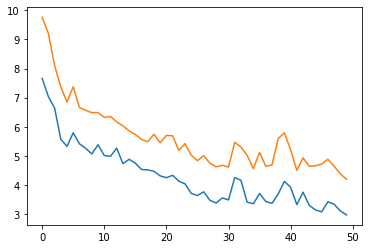

In [454]:
training_loss(MPNN,1e-3,32,50)

D-MPNN
lr: 0.01
batch size: 32
epochs: 50
Test loss: 5.4228716
Train loss: 3.802495


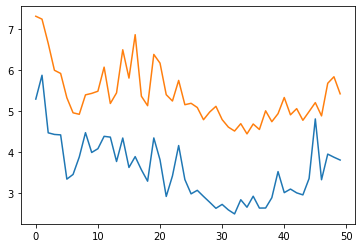

In [460]:
training_loss(DMPNN,1e-2,32,50)

MPNN with attention
lr: 0.001
batch size: 32
epochs: 50
Test loss: 4.644035
Train loss: 3.2364044


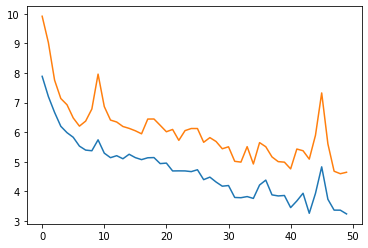

In [456]:
training_loss(MPNN_att,1e-3,32,50)

D-MPNN with attention
lr: 0.001
batch size: 32
epochs: 50
Test loss: 4.6767564
Train loss: 2.872537


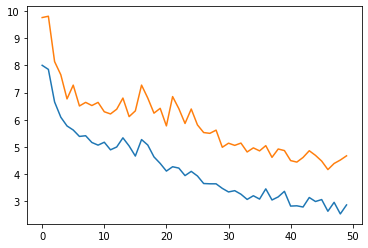

In [457]:
training_loss(DMPNN_att,1e-3,32,50)

RNN+NN
lr: 0.0001
batch size: 64
epochs: 50
Test loss: 3.9082751
Train loss: 1.3369806


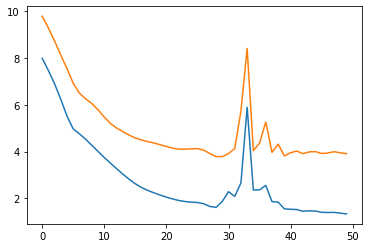

In [476]:
training_loss(RNN,1e-4,64,50)

RNN+NN with attention
lr: 0.0001
batch size: 64
epochs: 50
Test loss: 4.0558734
Train loss: 1.5999523


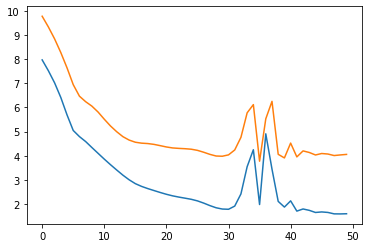

In [477]:
training_loss(RNN_att,1e-4,64,50)

---
## Training + testing

In [578]:
DMPNN = b.Model(name='D-MPNN',
                model=c.double_MPNN(atom_messages=False),
                model_type='torch',
                data_type='SMILES')
DMPNN_att = b.Model(name='D-MPNN with attention',
                    model=c.double_MPNN(atom_messages=False, interaction=True),
                    model_type='torch',
                    data_type='SMILES')
MPNN = b.Model(name='MPNN',
                model=c.double_MPNN(atom_messages=True),
                model_type='torch',
                data_type='SMILES')
MPNN_att = b.Model(name='MPNN with attention',
                    model=c.double_MPNN(atom_messages=True, interaction=True),
                    model_type='torch',
                    data_type='SMILES')
RNN = b.Model(name='RNN+NN',
              model=d.dnet(interaction=False),
              model_type='torch',
              data_type='sentences')
RNN_att = b.Model(name='RNN+NN with attention',
                  model=d.dnet(),
                  model_type='torch',
                  data_type='sentences')
RF_desc = b.Model(name='Random forest with descriptors',
                  model=RandomForestRegressor(n_estimators=1000, n_jobs=12),
                  model_type='sklearn',
                  data_type='descriptors')
RF_ECFP = b.Model(name='Random forest with ECFP',
                  model=RandomForestRegressor(n_estimators=1000, n_jobs=12),
                  model_type='sklearn',
                  data_type='ECFP')
MLP_desc = b.Model(name='MLP with descriptors',
                  model=MLPRegressor(hidden_layer_sizes=(200, 100)),
                  model_type='sklearn',
                  data_type='descriptors')
MLP_ECFP = b.Model(name='MLP with ECFP',
                  model=MLPRegressor(hidden_layer_sizes=(256, 128)),
                  model_type='sklearn',
                  data_type='ECFP')
RGB_desc = b.Model(name='RGBoost with descriptors',
                  model=XGBRegressor(n_jobs=12),
                  model_type='sklearn',
                  data_type='descriptors')
RGB_ECFP = b.Model(name='RGBoost with ECFP',
                  model=XGBRegressor(n_jobs=12),
                  model_type='sklearn',
                  data_type='ECFP')

#list of all models for testing
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, RGB_desc, RGB_ECFP]

In [577]:
imp.reload(b)

<module 'basicest' from '/Users/u6676643/codes/testing/basicest.py'>

In [405]:
#TODO: full CV training + testing
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res, full_res = b.CV_fit(m, data)
    
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

full_CV_test = pd.DataFrame(results)
print(full_CV_test)

testing D-MPNN ...
testing D-MPNN with attention ...
testing MPNN ...
testing MPNN with attention ...
testing RNN+NN ...
testing RNN+NN with attention ...
testing Random forest with descriptors ...
testing Random forest with ECFP ...
testing MLP with descriptors ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing MLP with ECFP ...
testing RGBoost with descriptors ...
testing RGBoost with ECFP ...
                             Model    MAE   RMSE
0                           D-MPNN  9.060 11.765
1            D-MPNN with attention  9.345 12.045
2                             MPNN  9.145 11.799
3              MPNN with attention 13.104 18.482
4                           RNN+NN  9.038 11.766
5            RNN+NN with attention  9.025 11.758
6   Random forest with descriptors  3.062  4.810
7          Random forest with ECFP  4.021  5.861
8             MLP with descriptors  7.678 12.406
9                    MLP with ECFP  3.906  5.657
10        RGBoost with descriptors  2.848  4.659
11               RGBoost with ECFP  3.970  6.005


In [ ]:
#TODO: holdout data test
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name)
    
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

In [ ]:
#TODO: dataset size vs accuracy

In [ ]:
#TODO: pka split vs accuracy

In [519]:
#LOSO
results = ddict(list)
solvent_set = list(set(solvent))

for solv in solvent_set:
    test_ids = [i for i, x in enumerate(solvent) if x == solv]
    size = len(test_ids)
    exp_name = "LOSO "+solv
    print('testing '+solv+' ...')
    for m in models:
        data = datasets[m.data_type]

        res = b.fit(m, data, test_ids, exp_name)

        results['Model'].append(m.name)
        results['LOSO solvent'].append(solv)
        results['Test size'].append(size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

LOSO_test = pd.DataFrame(results)
print(LOSO_test)

testing C1CCOC1 ...
testing O ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing CCCCCCC ...
testing COCCOC.COCCOC ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing CN(C)C=O ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing CS(=O)C ...
testing C(CCl)Cl ...
testing CC#N ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                       Model LOSO solvent  Test size    MAE   RMSE
0                     D-MPNN      C1CCOC1         65  6.233  7.802
1      D-MPNN with attention      C1CCOC1         65  4.778  6.622
2                       MPNN      C1CCOC1         65  5.437  6.810
3        MPNN with attention      C1CCOC1         65  6.133  8.490
4                     RNN+NN      C1CCOC1         65  5.070  6.641
..                       ...          ...        ...    ...    ...
91   Random forest with ECFP         CC#N        435  9.704 11.002
92      MLP with descriptors         CC#N        435 13.677 27.243
93             MLP with ECFP         CC#N        435 10.962 12.174
94  RGBoost with descriptors         CC#N        435  7.213  8.420
95         RGBoost with ECFP         CC#N        435 10.116 11.289

[96 rows x 5 columns]


In [518]:
#LOEO
results = ddict(list)
element_set = ['F','N','S','O','Cl','Br','P']

for ele in element_set:
    test_ids = [i for i, x in enumerate(solute) if ele in x]
    size = len(test_ids)
    exp_name = "LOEO "+ele
    print('testing '+ele+' ...')
    for m in models:
        data = datasets[m.data_type]

        res = b.fit(m, data, test_ids, exp_name)

        results['Model'].append(m.name)
        results['LOEO element'].append(ele)
        results['Test size'].append(size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

LOEO_test = pd.DataFrame(results)
print(LOEO_test)

testing F ...
testing N ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing S ...
testing O ...
testing Cl ...
testing Br ...
                       Model LOEO element  Test size    MAE   RMSE
0                     D-MPNN            F        282 11.330 14.998
1      D-MPNN with attention            F        282 11.475 16.343
2                       MPNN            F        282 11.362 15.319
3        MPNN with attention            F        282 13.186 16.541
4                     RNN+NN            F        282 11.311 15.400
..                       ...          ...        ...    ...    ...
67   Random forest with ECFP           Br         21  4.665  6.634
68      MLP with descriptors           Br         21 12.604 17.247
69             MLP with ECFP           Br         21  4.214  5.441
70  RGBoost with descriptors           Br         21  2.015  2.525
71         RGBoost with ECFP           Br         21  3.636  5.344

[72 rows x 5 columns]


In [490]:
#LOMO
results = ddict(list)
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in solute]
mass_cutoffs = [100,150,200,250,300]

for mass in mass_cutoffs:
    test_ids = [i for i, x in enumerate(solute_masses) if x > mass]
    size = len(test_ids)
    exp_name = "LOMO >"+str(mass)+'g/mol'
    print('testing >'+str(mass)+'g/mol ...')
    for m in models:
        data = datasets[m.data_type]

        res = b.fit(m, data, test_ids, exp_name)

        results['Model'].append(m.name)
        results['LOMO mass cutoff'].append(mass)
        results['Test size'].append(size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

LOMO_test = pd.DataFrame(results)
print(LOMO_test)

testing >100g/mol ...
testing >150g/mol ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing >200g/mol ...
testing >250g/mol ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing >300g/mol ...
                             Model  LOMO mass cutoff  Test size    MAE   RMSE
0                           D-MPNN               100        750  9.202 12.691
1            D-MPNN with attention               100        750 10.324 14.736
2                             MPNN               100        750  9.452 13.351
3              MPNN with attention               100        750  9.895 12.813
4                           RNN+NN               100        750  9.403 13.272
5            RNN+NN with attention               100        750  9.368 13.231
6   Random forest with descriptors               100        750  6.500  8.686
7          Random forest with ECFP               100        750  5.759  7.375
8             MLP with descriptors               100        750 21.849 29.034
9                    MLP with ECFP               100        750  5.978  7.684
10        RGBoost with descriptors               100        750  6.962  9.505
11               RGBoost with ECFP        

In [489]:
#LOCO
results = ddict(list)
solute_charges = [GetFormalCharge(Chem.MolFromSmiles(mol)) for mol in solute]
charge_list = [0,1]

for charge in charge_list:
    test_ids = [i for i, x in enumerate(solute_charges) if x == charge]
    size = len(test_ids)
    exp_name = "LOCO "+str(charge)
    print('testing >'+str(charge)+' ...')
    for m in models:
        data = datasets[m.data_type]

        res = b.fit(m, data, test_ids, exp_name)

        results['Model'].append(m.name)
        results['LOCO charge'].append(charge)
        results['Test size'].append(size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

LOCO_test = pd.DataFrame(results)
print(LOCO_test)

testing >0 ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing >1 ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                             Model  LOCO charge  Test size    MAE   RMSE
0                           D-MPNN            0        580 10.705 14.525
1            D-MPNN with attention            0        580 11.875 16.238
2                             MPNN            0        580 10.966 14.932
3              MPNN with attention            0        580 11.154 14.462
4                           RNN+NN            0        580 11.043 15.091
5            RNN+NN with attention            0        580 11.019 15.055
6   Random forest with descriptors            0        580 12.764 17.393
7          Random forest with ECFP            0        580 12.113 16.629
8             MLP with descriptors            0        580 20.304 26.066
9                    MLP with ECFP            0        580 11.574 16.476
10        RGBoost with descriptors            0        580 13.268 17.729
11               RGBoost with ECFP            0        580 12.453 17.110
12                          D-MPNN            1    

In [547]:
data = datasets["SMILES"]
MPNN.num_epochs=50
res = b.fit(MPNN, data, holdout_ids, "test")

tensor(0.9517, grad_fn=<MseLossBackward>)
tensor(0.9359, grad_fn=<MseLossBackward>)
tensor(0.9191, grad_fn=<MseLossBackward>)
tensor(0.9450, grad_fn=<MseLossBackward>)
tensor(0.9377, grad_fn=<MseLossBackward>)
tensor(0.9367, grad_fn=<MseLossBackward>)
tensor(0.9363, grad_fn=<MseLossBackward>)
tensor(0.9201, grad_fn=<MseLossBackward>)
tensor(0.9213, grad_fn=<MseLossBackward>)
tensor(0.9266, grad_fn=<MseLossBackward>)
tensor(0.9427, grad_fn=<MseLossBackward>)
tensor(0.9347, grad_fn=<MseLossBackward>)
tensor(0.9403, grad_fn=<MseLossBackward>)
tensor(0.9269, grad_fn=<MseLossBackward>)
Early stopping
13


In [593]:
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = b.fit(m, data, holdout_ids, exp_name, datasets)
    
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

holdout_test = pd.DataFrame(results)
print(holdout_test)

testing D-MPNN ...
Early stopping
testing D-MPNN with attention ...
Early stopping
testing MPNN ...
Early stopping
testing MPNN with attention ...
Early stopping
testing RNN+NN ...
Early stopping
testing RNN+NN with attention ...
Early stopping
testing Random forest with descriptors ...
testing Random forest with ECFP ...
testing MLP with descriptors ...


/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


testing MLP with ECFP ...
testing RGBoost with descriptors ...
testing RGBoost with ECFP ...
                             Model    MAE   RMSE
0                           D-MPNN  8.522 11.854
1            D-MPNN with attention 11.852 16.725
2                             MPNN  8.454 11.492
3              MPNN with attention 12.617 15.898
4                           RNN+NN  8.569 11.527
5            RNN+NN with attention  8.615 11.529
6   Random forest with descriptors  2.344  3.603
7          Random forest with ECFP  2.760  4.122
8             MLP with descriptors  5.981  9.205
9                    MLP with ECFP  2.634  3.827
10        RGBoost with descriptors  2.004  3.045
11               RGBoost with ECFP  2.448  3.938


In [585]:
outputs.reshape(893,).shape

(893,)

In [595]:
results = ddict(list)
results['targets'] = datasets['ECFP'][1]
for m in models:
    data = datasets[m.data_type]
    _, outputs = b.predict(m, m.experiments[0], data)
    results[m.name] = outputs.reshape(893,)
    
output_results = pd.DataFrame(results)
print(output_results)

     targets  D-MPNN  D-MPNN with attention   MPNN  MPNN with attention  \
0      8.800  14.015                 15.317 16.841               18.355   
1     43.600  13.418                 14.831 18.160               13.370   
2     13.500  14.470                 12.823 15.667               13.871   
3      7.960  15.489                 14.702 15.080               16.036   
4     10.100  14.685                 14.831 15.553               17.027   
..       ...     ...                    ...    ...                  ...   
888   32.200  13.166                 12.533 15.632               18.889   
889    3.380  13.762                 14.463 16.320               16.359   
890   34.700  13.077                 15.255 14.112               17.713   
891   42.800  14.248                 13.928 15.808               16.691   
892    7.467  13.285                 12.907 15.202               21.176   

     RNN+NN  RNN+NN with attention  Random forest with descriptors  \
0    15.940                 1

In [592]:
imp.reload(b)

<module 'basicest' from '/Users/u6676643/codes/testing/basicest.py'>

In [597]:
output_results.to_csv('output_results.csv')